## Importing packages and modules

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


import pickle
import yaml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import Dataset
from neuralnetworks import DynamicSeqRegNN, RegressionDataset

In [97]:
print(os.getcwd())
training = True

c:\Users\balaj\Desktop\Projects\Predictive_Maintenance-NASA_Turbofan_Jet_Engine\FD001 Analysis


In [98]:
# Importing and refreshing modules
import importlib
import preprocess

importlib.reload(preprocess)
from preprocess import Preprocessor, Charting


if training == True:
    p = Preprocessor()
else:
    #  Load the model from the pickle file
    with open('./saved_scalers/minmaxscaler.pkl', 'rb') as file:
        saved_scaler = pickle.load(file)
    p = Preprocessor(scaler=saved_scaler)
c = Charting()


In [99]:
# Loading data
train = pd.read_table("../Data/train_FD001.txt", sep=' ', header=None)

## Cleaning and Preprocessing

In [100]:
# Renaming columns
train = p.rename_columns(train)
train.head()

,unit,cycles,ops1,ops2,ops3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [101]:
# Dropping empty columns
train = train.dropna(axis=1, how='all')
list(train.isna().sum()) # Checking for missing values in each column

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

It is important to understand the source of our data here. The data is the result of a simulation and therefore outliers due to data entry errors or environmental factors are ruled out. Outlier Sensor values could hold key information about the health of the engine. Thus we will not remove them. 

In [102]:
train.describe()

,unit,cycles,ops1,ops2,ops3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [103]:
# Dropping cols where the min and max are same. i.e. No information is gained
train = p.drop_no_info_cols(train)

In [104]:
# Creating RUL column
train = p.create_rul_col(train)


In [105]:
# Updating column groups
sensor_cols, op_setting_cols, other_cols = p.update_col_groups(train)

In [106]:
c.plot_max_cycles_dist(train)

In [107]:
# Let us normalize the operating setting and sensor values for each unit
train_norm = p.normalize(train, sensor_cols + op_setting_cols)


In [108]:
if training == True:
    with open('./saved_scalers/minmaxscaler.pkl', 'wb') as file:
        pickle.dump(p.get_minmaxscaler(), file)

In [109]:
# Assuming all the sensor variation is similar in all units, let us group by cycles and take mean
grouped_train_norm = p.group_by_rul(train_norm, cols=(op_setting_cols+sensor_cols))

In [110]:
# Plotting sensor values
c.plot_avg_sensor_data(grouped_train_norm, sensor_cols)

In [111]:
# Plotting sensor values for a specific unit
specific_unit = 5
train_specific_unit = train[train['unit'] == specific_unit]
px.line(train_specific_unit, x='rul', y=sensor_cols, title=f'Sensor values vs cycle for unit {specific_unit}')

We observe that the relationship between the features is linear, so we will not go ahead with PCA. 

In [112]:
# Observing standard deviation of sensor values
grouped_train_by_unit = train.groupby('unit')
grouped_train_by_unit.std()

,cycles,rul,ops1,ops2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
unit,,,,,,,,,,,,,,,,,,,
1,55.569776,55.569776,0.001953,0.000282,0.486795,5.759776,8.565610,0.000000,0.910414,0.070914,4.911853,0.268346,0.749176,0.076960,5.563129,0.034125,1.475661,0.166998,0.105101
2,82.993976,82.993976,0.002320,0.000298,0.560214,6.596730,9.737248,0.002491,0.940728,0.063001,12.491827,0.293672,0.799368,0.063861,8.683012,0.041128,1.647280,0.199332,0.114796
3,51.816986,51.816986,0.002145,0.000290,0.474190,6.386222,8.610126,0.001482,0.733983,0.039957,35.196825,0.242410,0.594788,0.041219,29.439715,0.036620,1.570773,0.166112,0.104734
4,54.703748,54.703748,0.002033,0.000286,0.441446,6.109152,7.737463,0.000727,0.708327,0.032530,36.571690,0.222724,0.530158,0.034819,30.691780,0.031947,1.602848,0.159302,0.093804
5,77.797815,77.797815,0.002119,0.000279,0.551542,7.060648,9.782341,0.002503,0.895734,0.055522,21.404031,0.285740,0.753298,0.056445,16.480153,0.038658,1.740057,0.187133,0.112705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97.139076,97.139076,0.002088,0.000277,0.501021,5.853261,8.791019,0.001086,0.864553,0.060982,6.994209,0.260853,0.707257,0.060729,4.179830,0.035970,1.513053,0.180457,0.106394
97,58.456537,58.456537,0.002112,0.000288,0.473922,6.164926,7.668898,0.000993,0.671497,0.040905,40.436586,0.208634,0.534132,0.036208,33.877407,0.034042,1.561475,0.170961,0.093300
98,45.177428,45.177428,0.002144,0.000275,0.525905,6.312261,9.751562,0.001378,0.898644,0.078068,5.040509,0.297087,0.774711,0.074219,5.859512,0.035768,1.407692,0.177168,0.107449


<module 'matplotlib.pyplot' from 'c:\\Users\\balaj\\anaconda3\\envs\\predictive_manintenance_project\\Lib\\site-packages\\matplotlib\\pyplot.py'>

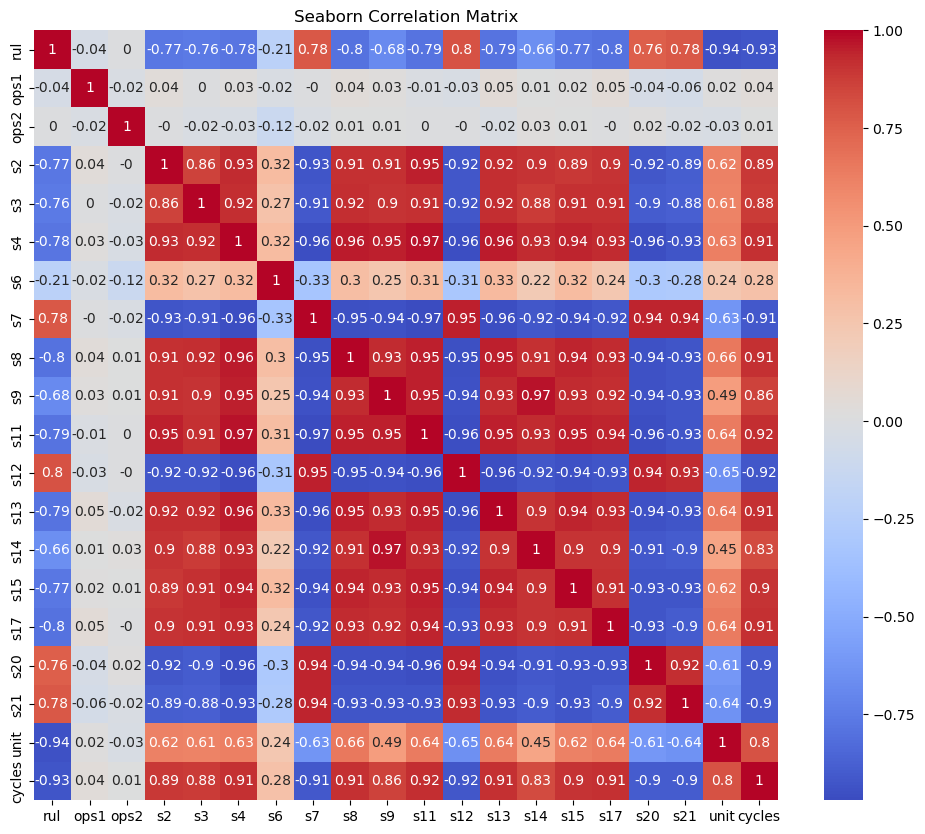

In [113]:
# Plotting corrrelation values
c.plot_corr_heatmap(grouped_train_norm)

In [114]:
train

,unit,cycles,rul,ops1,ops2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,191,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,190,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,189,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,188,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,187,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,4,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,3,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,2,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,1,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [115]:
# Performing PCA for dimensionality reduction
predicting_cols = ['cycles'] + sensor_cols + op_setting_cols
pca = PCA()
pca.fit(train_norm[predicting_cols])
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance) # 99% of the variance is explained by the first component

X_pca = pca.transform(train_norm[predicting_cols])[:,:1]

[0.99994372 0.99996437 0.99997694 0.99998099 0.99998482 0.99998815
 0.99998984 0.99999138 0.99999278 0.99999409 0.99999533 0.99999643
 0.99999735 0.99999823 0.99999901 0.99999952 0.99999994 1.        ]


We see that the most sensor values show strong postive or strong negative correlation with the cycles column.

## Model Training

In [116]:
# Split the normalized data into X and y
X_npca = train_norm.drop(columns=['rul', 'unit'])
y = train_norm['rul']

# Split the data into training and testing sets
X_train_npca, X_test_npca, y_train_npca, y_test_npca = train_test_split(X_npca, y, test_size=0.2, random_state=42)

In [117]:
# Splitting the PCA data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# X_test_copy = X_test.copy()
# X_test_copy['rul'] = y_test

Before using the PCA data let us see feature importance for which actual features have to be used.

### Random Forest - Non-PCA 

In [ ]:
%%time

# Create the Random Forest model
rf_non_pca = RandomForestRegressor()

# Train the model
rf_non_pca.fit(X_train_npca, y_train_npca)

# Make predictions
y_pred = rf_non_pca.predict(X_test_npca)

# Evaluate the model
mse = mean_squared_error(y_test_npca, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_npca, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Root Mean Squared Error: 36.1175595802305
R-squared: 0.7144809354687596
CPU times: total: 19.6 s
Wall time: 18.9 s


In [119]:
feature_importances_df = pd.DataFrame({'feature':list(X_train_npca.columns),'feature_imp':list(rf_non_pca.feature_importances_)})
px.bar(feature_importances_df, x='feature', y='feature_imp', title='Feature Importances of Random Forest Model')

We observe that the columns: cycles, sensor 11, sensor 4 and sensor 9 are the most important features in predicting the RUL.

### Random Forest - PCA

#### Base Model without optimized hyperparameters

In [ ]:
%%time

# Create the Random Forest model
rf_model = RandomForestRegressor()

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Root Mean Squared Error: 44.97222632665251
R-squared: 0.5573228639967842
CPU times: total: 3.2 s
Wall time: 3.21 s


#### Hyperparameters tuning with GridSearchCV

In [ ]:
%%time
if training == True:    
    
    # Create the Random Forest model
    rf_model = RandomForestRegressor()

    # Define the parameter grid
    param_grid = { # The param grid has been reduced after running the grid search once
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [None, 5, 10],
        'min_samples_split': [5, 6],
        'min_samples_leaf': [7, 10, 12],
        'bootstrap': [True]
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(
        estimator=rf_model, 
        param_grid=param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error', 
        verbose=1, 
        n_jobs=-1
    )

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f'Best Parameters: {best_params}')
    print(f'Best Score: {best_score}')

    # Train the model with the best parameters
    best_rf_model = grid_search.best_estimator_
    best_rf_model.fit(X_train, y_train)

else:
    # Load the model from the pickle file
    with open('./saved_models/Random Forest/rf_model.pkl', 'rb') as file:
        best_rf_model = pickle.load(file)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 500}
Best Score: -1655.5872926441393
Root Mean Squared Error: 39.96739236183609
R-squared: 0.6503689903759218
CPU times: total: 24.1 s
Wall time: 2min 55s


In [122]:
comparing_pred_df = pd.DataFrame(columns=['y_ground', 'y_rf', 'y_xgb', 'y_nn'])
comparing_pred_df['y_ground'] = y_test
comparing_pred_df['y_rf'] = y_pred

Though the RMSE and R squared values are lower compared to rf model without PCA we will use this model as it would generalize better.

In [123]:
# Saving the xgboost model and parameters
if training == True:
    with open('./saved_models/Random Forest/rf_model.pkl', 'wb') as f:
        pickle.dump(best_rf_model, f)
        
    with open('./saved_models/Random Forest/rf_hyperparameters.yaml', 'w') as f:
        yaml.dump(best_rf_model.get_params(), f)

### XGBoost

In [ ]:
%%time
if training==True:
    

    # Create the XGBoost model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

    # Define the parameter grid
    param_grid = {
        'n_estimators': [25, 50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(
        estimator=xgb_model, 
        param_grid=param_grid, 
        cv=5, 
        scoring='neg_mean_squared_error', 
        verbose=1, 
        n_jobs=-1
    )

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f'Best Parameters: {best_params}')
    print(f'Best Score: {best_score}')

    # Train the model with the best parameters
    best_xgb_model = grid_search.best_estimator_
    best_xgb_model.fit(X_train, y_train)

    # Predictions
    y_pred = best_xgb_model.predict(X_test)

    # Evaluating the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'Root Mean Squared Error: {rmse}')
    print(f'R-squared: {r2}')



Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Best Score: -1972.9732421875
Root Mean Squared Error: 42.996564860971745
R-squared: 0.5953627228736877
CPU times: total: 6.81 s
Wall time: 23 s


In [125]:
# Saving the xgboost model and parameters
if training == True:
    with open('./saved_models/XGBoost/xgb_model.pkl', 'wb') as f:
        pickle.dump(best_xgb_model, f)
        
    with open('./saved_models/XGBoost/xgb_hyperparameters.yaml', 'w') as f:
        yaml.dump(best_xgb_model.get_params(), f)

In [126]:
comparing_pred_df['y_xgb'] = y_pred

### Neural Network

In [128]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


In [129]:
# Creating tensors for train and test split data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [131]:
# Creating Dataset & DataLoader
batch_size = 120  
train_dataset = RegressionDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [132]:
# Initialize Model
model = DynamicSeqRegNN(input_size=X_train_tensor.shape[1], hidden_sizes=[128, 64, 32])#, dropout=0.1)

# Defining training parameters
learning_rate = 0.001
num_epochs = int(4e3)

# Defining loss function
loss_fn = nn.MSELoss(reduction='sum') # Reduction tell how to aggregate the loss for multiple elements in a batch/input

# Selecting optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # Passing weights to the model to optimizer
 
# Adding a Learning Rate Scheduler (Reduces LR when loss stops improving)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_loss = float('inf')  # Store best loss
best_model = None
loss_rmse_df = pd.DataFrame(columns=['epoch', 'loss', 'rmse'])

# Training loop
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        # Steps: Forward pass, calculate loss, zero gradients, backward pass, update weights and reduce lr if loss plateaus
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = model.state_dict()
        
    # Model evaluation and printing loss
    if epoch % 100 == 99:
        print(f'Epoch {epoch+1}, Loss {loss.item()}')
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor)
        mse = loss_fn(y_pred, y_test_tensor)
        rmse = torch.sqrt(mse)
        logged_data = {'epoch': epoch+1, 'loss': loss.item(), 'rmse': rmse}
        loss_rmse_df.loc[len(loss_rmse_df)] = logged_data


Epoch 100, Loss 198051.046875
Epoch 200, Loss 197175.15625
Epoch 300, Loss 196671.359375
Epoch 400, Loss 196375.9375
Epoch 500, Loss 196190.8125
Epoch 600, Loss 196059.6875
Epoch 700, Loss 195969.859375
Epoch 800, Loss 195917.390625
Epoch 900, Loss 195879.5625
Epoch 1000, Loss 195857.046875
Epoch 1100, Loss 195849.390625
Epoch 1200, Loss 195844.140625
Epoch 1300, Loss 195838.828125
Epoch 1400, Loss 195833.359375
Epoch 1500, Loss 195827.828125
Epoch 1600, Loss 195822.21875
Epoch 1700, Loss 195816.59375
Epoch 1800, Loss 195810.984375
Epoch 1900, Loss 195805.328125
Epoch 2000, Loss 195799.609375
Epoch 2100, Loss 195793.890625
Epoch 2200, Loss 195788.15625
Epoch 2300, Loss 195782.40625
Epoch 2400, Loss 195776.625
Epoch 2500, Loss 195770.78125
Epoch 2600, Loss 195764.921875
Epoch 2700, Loss 195759.015625
Epoch 2800, Loss 195753.171875
Epoch 2900, Loss 195747.296875
Epoch 3000, Loss 195741.40625
Epoch 3100, Loss 195735.53125
Epoch 3200, Loss 195729.625
Epoch 3300, Loss 195723.71875
Epoch 340

In [133]:
# px.line(loss_rmse_df, x='epoch', y= 'loss', title='Loss vs RMSE')
fig = px.line(loss_rmse_df, x='epoch', y='rmse', title='epoch vs RMSE of validation data')
fig 


In [134]:
# Displaying Neural Network Model layers
for name, module in model.named_modules():
    print(f"{name}: {module}")

torch.save(model, "./saved_models/Neural Networks/NN_seq_model.pth")
torch.save(model.state_dict(), "./saved_models/Neural Networks/NN_seq_model_weights.pth")

: DynamicSeqRegNN(
  (activation): ReLU()
  (model): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)
activation: ReLU()
model: Sequential(
  (0): Linear(in_features=1, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
model.0: Linear(in_features=1, out_features=128, bias=True)
model.2: Linear(in_features=128, out_features=64, bias=True)
model.4: Linear(in_features=64, out_features=32, bias=True)
model.6: Linear(in_features=32, out_features=1, bias=True)


In [135]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
mse = loss_fn(y_pred, y_test_tensor)
rmse = torch.sqrt(mse)
r2 = r2_score(y_test_tensor, y_pred.detach().numpy())
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Root Mean Squared Error: 4234.59326171875
R-squared: 0.04898494482040405


The model performace of the neural network is very poor compared to the rf and xgboost models

In [138]:
comparing_pred_df['y_nn'] = y_pred
comparing_pred_df

,y_ground,y_rf,y_xgb,y_nn
13857,135,44.047410,42.627247,58.141872
1710,2,19.962917,64.518539,19.417860
9278,217,209.991056,191.169922,223.674576
10786,0,24.649913,33.350025,72.850594
19709,178,110.241998,57.717148,24.317833
...,...,...,...,...
8260,184,203.531564,185.568741,202.474426
20527,103,101.133354,108.443657,28.149433
16016,121,136.854960,139.221634,105.885048
2271,104,131.297380,72.808304,13.532834
